# Wetland visualisation

**Background**

**What does this notebook do?** This notebook visualises raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [2]:
import functools
from multiprocessing.pool import Pool
import multiprocessing
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import datacube.utils.geometry
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
import scipy.stats
import seaborn
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
import sklearn.metrics
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

/g/data/v10/public/modules/dea/20200617/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [3]:
dc = datacube.Datacube(app='wetland-visualisation')

The following dataset is a sample of wetland and non-wetland across Queensland generated in `WetlandHistograms2.ipynb`.

In [4]:
df = xarray.open_dataset('wetland_data_sample_unbalanced_old.nc').to_dataframe()

In [5]:
df = df[::10]  # 9 -> 1 GB

Vectorise the wetland features so they can be used in visualisation methods.

In [6]:
features = np.stack([
    df.TCW10,
    df.TCW50,
    df.TCW90,
    df.TCW95,
    df.TCG10,
    df.TCG50,
    df.TCG90,
    df.TCG95,
    df.PV90,
    df.PV50,
    df.PV10,
    np.where(np.isnan(df.MrVBF), -1, df.MrVBF),
    df.Koppen,
    df.TCW95 - df.TCW90,
    df.TCW95 - df.TCW50,
    df.TCW95 - df.TCW10,
    df.TCW90 - df.TCW50,
    df.TCW90 - df.TCW10,
    df.TCW50 - df.TCW10,
    df.TCG95 - df.TCG90,
    df.TCG95 - df.TCG50,
    df.TCG95 - df.TCG10,
    df.TCG90 - df.TCG50,
    df.TCG90 - df.TCG10,
    df.TCG50 - df.TCG10,
    df.PV90 - df.PV10,
    df.PV50 - df.PV10,
    df.PV90 - df.PV50,
]).T

In [7]:
feature_names = [
    'TCW10',
    'TCW50',
    'TCW90',
    'TCW95',
    'TCG10',
    'TCG50',
    'TCG90',
    'TCG95',
    'PV90',
    'PV50',
    'PV10',
    'MrVBF',
    'Koppen',
    'TCW(95-90)',
    'TCW(95-50)',
    'TCW(95-10)',
    'TCW(90-50)',
    'TCW(90-10)',
    'TCW(50-10)',
    'TCG(95-90)',
    'TCG(95-50)',
    'TCG(95-10)',
    'TCG(90-50)',
    'TCG(90-10)',
    'TCG(50-10)',
    'PV(90-0)',
    'PV(50-0)',
    'PV(90-0)',
]

## Visualising the feature space

Let's apply PCA and tSNE on our data.

In [8]:
wetland_classes = ['Non-wetland', 'Lacustrine', 'Palustrine', 'Riverine']

In [311]:
import sklearn.decomposition

In [312]:
pca = sklearn.decomposition.PCA(n_components=2)

In [313]:
pca_f = pca.fit_transform(features)

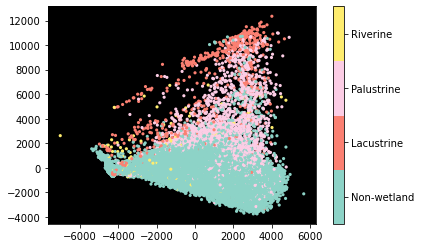

In [314]:
plt.subplot(1, 1, 1, facecolor='k')
cmap = matplotlib.cm.Set3
plt.scatter(pca_f[::100, 0], pca_f[::100, 1], s=10, edgecolor='None', c=df.Wetland[::100], norm=matplotlib.colors.BoundaryNorm(range(5), cmap.N), cmap=cmap)
cb = plt.colorbar()
cb.set_ticks(np.arange(4) + 0.5)
cb.set_ticklabels(wetland_classes)

In [315]:
import sklearn.manifold

In [316]:
tsne = sklearn.manifold.TSNE(perplexity=50, random_state=1)

In [317]:
tsne_f = tsne.fit_transform(features[::500])

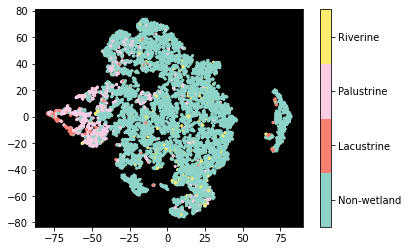

In [318]:
plt.subplot(1, 1, 1, facecolor='k')
cmap = matplotlib.cm.Set3
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], s=10, edgecolor='None', c=df.Wetland[::500], norm=matplotlib.colors.BoundaryNorm(range(5), cmap.N), cmap=cmap)
cb = plt.colorbar()
cb.set_ticks(np.arange(4) + 0.5)
cb.set_ticklabels(wetland_classes)

This shows that we can at least expect some separation, but it doesn't show us much else.

## Visualising accuracy measures

Let's try to view the precision and recall for TCG cuts to get a feel for what these measures look like on the dataset. Precision is the true positives divided by the total predicted positives, and recall is the true positives divided by the total number of groundtruth positives.

Once we make a cut on TCW 95 > -600, we can then make a cut on TCG 50. Let's set one threshold for all Koppen zones, MrVBF values, etc. Then TCG 50 is the predictor, and we can plot a precision-recall curve.

In [9]:
min_tcg = df.TCG50.min()
min_tcg

-1126

In [43]:
decisions = np.where(df.TCW95 <= -600, -min_tcg, -df.TCG50)

In [44]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(df.Wetland > 0, decisions)

Text(0, 0.5, 'Precision')

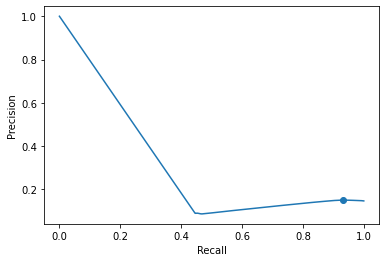

In [45]:
plt.plot(recall, precision)
marker = precision[:-1].argmax()
plt.scatter(recall[marker], precision[marker])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [42]:
thresholds[marker]

-87

What's super cool is that we can divide this by wetland type.

Text(0, 0.5, 'Precision')

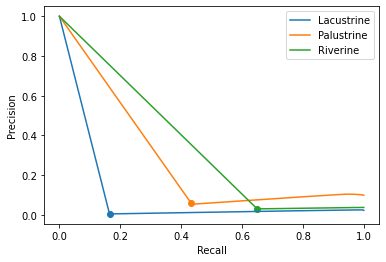

In [27]:
for i in range(1, 4):
    mask = df.Wetland.isin({0, i})
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(df.Wetland[mask] > 0, decisions[mask])
    plt.plot(recall, precision, label=wetland_classes[i])
    marker = np.abs(thresholds - 1000).argmin()
    plt.scatter(recall[marker], precision[marker], marker='o')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

Or by Koppen zone.

In [324]:
koppen_titles = ['Ocean', 'Af', 'Am', 'Aw', 'BWh', 'BWk', 'BSh', 'BSk', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb', 'Cwc',
                 'Cfa', 'Cfb', 'Cfc', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd', 'Dfa',
                 'Dfb', 'Dfc', 'Dfd', 'ET', 'EF']

Text(0, 0.5, 'Precision')

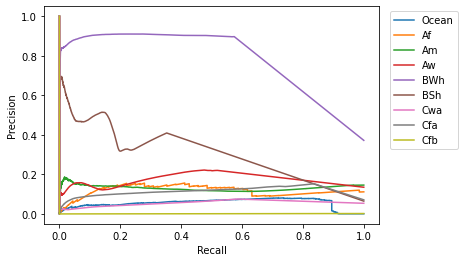

In [325]:
for i in range(0, 16):
    df_ = df[df.Koppen == i]
    if len(np.unique(df_.Wetland > 0)) < 2:
        # Otherwise there's only one class, and precision/recall fails.
        continue
    mask = df.Koppen == i
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(df.Wetland[mask] > 0, decisions[mask])
    plt.plot(recall, precision, label=koppen_titles[i])
#     marker = np.abs(thresholds - -600).argmin()
#     plt.scatter(recall[marker], precision[marker])
plt.legend(bbox_to_anchor=(1.25, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')

Or by MrVBF.

Text(0, 0.5, 'Precision')

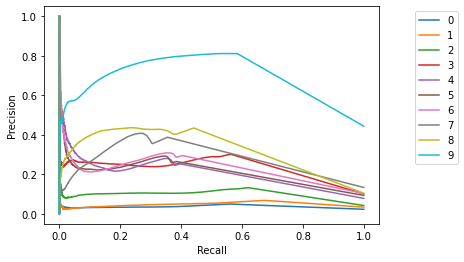

In [326]:
for i in range(0, 10):
    df_ = df[df.MrVBF == i]
    if len(np.unique(df_.Wetland > 0)) < 2:
        # Otherwise there's only one class, and precision/recall fails.
        continue
    mask = df.MrVBF == i
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(df.Wetland[mask] > 0, decisions[mask])
    plt.plot(recall, precision, label=i)
#     marker = np.abs(thresholds - -600).argmin()
#     plt.scatter(recall[marker], precision[marker])
plt.legend(bbox_to_anchor=(1.25, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')

## Decision trees for each climate zone

What if we fit a decision tree to each climate zone, enforcing TCW 95 > -600 and only allowing decisions along the TCG 50 axis?

In [327]:
import sklearn.tree

In [328]:
trees = {z: sklearn.tree.DecisionTreeClassifier(max_depth=1) for z in range(16)}

In [329]:
k = feature_names.index('TCG50')
for z in tqdm(range(16)):
    mask = (df.Koppen == z) & (df.TCW95 > -600)
    if mask.sum() == 0:
        continue
    trees[z].fit(features[mask][::100, k:k+1], df.Wetland[mask][::100] > 0)

In [330]:
thresholds = {i: trees[i].tree_.threshold[0] for i in np.unique(df.Koppen)}

In [331]:
thresholds

{0: 1608.5,
 1: 2036.0,
 2: 1195.5,
 3: 1037.5,
 4: 35.5,
 6: -72.0,
 7: -2.0,
 11: 714.5,
 14: 84.5,
 15: -2.0}

Let's define a classifier that applies the appropriate tree.

In [332]:
def predict_trees(X):
    koppen = X[:, feature_names.index('Koppen')]
    predictions = np.zeros(koppen.shape, dtype=bool)
    for z in range(16):
        tree = trees[z]
        if not (koppen == z).any():
            continue
        predictions[koppen == z] = tree.predict(X[koppen == z, k:k+1])
    tcw95 = X[:, feature_names.index('TCW95')]
    predictions[tcw95 <= -600] = False
    return predictions

In [348]:
class TreePredictor(sklearn.base.ClassifierMixin):
    classes_ = [0, 1]
    def predict(self, X):
        return predict_trees(X)

In [333]:
tree_predictions = predict_trees(features)

In [334]:
sklearn.metrics.accuracy_score(df.Wetland > 0, tree_predictions)

0.9023700007956006

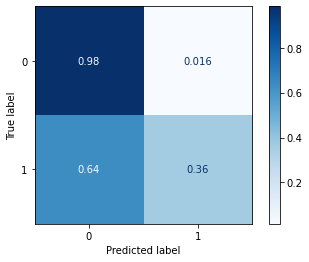

In [351]:
sklearn.metrics.plot_confusion_matrix(TreePredictor(), features, df.Wetland > 0, normalize='true', cmap='Blues')

In [335]:
sklearn.metrics.accuracy_score(df.Wetland > 0, (df.TCW95 > -600) & (df.TCG50 < np.where(df.MrVBF > 3, 1400, 1000)))

0.8157881358849393

Let's repeat that for MrVBF instead of Koppen.

In [336]:
trees = {z: sklearn.tree.DecisionTreeClassifier(max_depth=1) for z in range(10)}

In [337]:
k = feature_names.index('TCG50')
for z in tqdm(range(16)):
    mask = (df.MrVBF == z) & (df.TCW95 > -600)
    if mask.sum() == 0:
        continue
    trees[z].fit(features[mask][::100, k:k+1], df.Wetland[mask][::100] > 0)

In [338]:
thresholds = {i: trees[i].tree_.threshold[0] for i in range(10)}

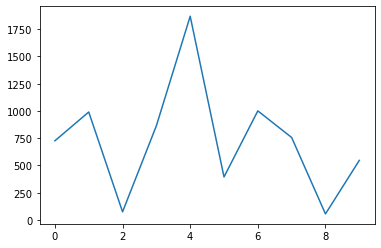

In [339]:
plt.plot(np.arange(10), [thresholds[i] for i in range(10)])

Let's define a classifier that applies the appropriate tree.

In [340]:
def predict_trees(X):
    mrvbf = X[:, feature_names.index('MrVBF')]
    predictions = np.zeros(mrvbf.shape, dtype=bool)
    for z in range(10):
        tree = trees[z]
        if not (mrvbf == z).any():
            continue
        predictions[mrvbf == z] = tree.predict(X[mrvbf == z, k:k+1])
    tcw95 = X[:, feature_names.index('TCW95')]
    predictions[tcw95 <= -600] = False
    return predictions

In [341]:
tree_predictions = predict_trees(features)

In [342]:
sklearn.metrics.accuracy_score(df.Wetland > 0, tree_predictions)

0.8926543265742235

In [343]:
sklearn.metrics.accuracy_score(df.Wetland > 0, (df.TCW95 > -600) & (df.TCG50 < np.where(df.MrVBF > 3, 1400, 1000)))

0.8157881358849393